# AlexNet model training Notebook

 ## Data Preprocessing

In [2]:
"""
Import Libraries and Set Random Seed
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, sampler, random_split
import numpy as np
from collections import namedtuple
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
import os
import pandas as pd
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from torch.optim.lr_scheduler import LambdaLR
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import random
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt

#define pytorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#torch.cuda.set_per_process_memory_fraction(0.5, 0)


SEED = 111
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
"""
Use pipeline detailed in data_prep_training.py to import the dataloaders for model training:
"""
from data_prep_training import get_dataloaders

path = '../../data/preprocessed_renamed'

train_loader, val_loader, test_loader = get_dataloaders(path, batch_size=150, img_size=(100, 100), train_ratio=0.8, val_ratio=0.05)


In [3]:
# torch.save(train_loader, './output/train_loader.pth')

# torch.save(val_loader, './output/val_loader.pth')

# torch.save(test_loader, './output/test_loader.pth')

train_loader = torch.load('./output/train_loader.pth')
val_loader = torch.load('./output/val_loader.pth')
test_loader = torch.load('./output/test_loader.pth')

 ## Defining a ResNet101

In [19]:
"""
Load pretrained ResNet101 model that will be fine-tuned with the MRI dataset.
MRI dataset has 5 classes of Lumbar Spine Degenerative Conditions.
"""
model = models.resnet101(weights = models.ResNet101_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 5) #change to 5 outputs for the 5 classes
model = model.to(device)


In [4]:
"""
Eval/train function
"""

def eval_or_train(model, dataloader, optimizer, criterion, device, mode = 'eval'):
    if mode == 'train':
        #init training mode
        model.train()
        #init running loss, correct preds, and total correct preds for each epoch
        epoch_total_loss = 0.0
        epoch_correct_preds = 0
        epoch_total_preds = 0
        all_labels = []
        all_preds = []

        for _, (data,target) in enumerate(dataloader):
            
            #init data and target into cuda
            data = data.to(device)
            target = target.to(device)

            
            optimizer.zero_grad()
            #predict using input data
            curr_pred = model(data)
            #calculate loss of prediction with true label
            curr_loss = criterion(curr_pred, target)

            #backprop
            curr_loss.backward()
            #gradient descent step
            optimizer.step()

            epoch_total_loss += curr_loss.item() * data.size(0)
            _, predicted = torch.max(curr_pred, 1)

            epoch_correct_preds += (predicted == target).sum().item()
            epoch_total_preds += target.size(0)

            all_labels.extend(target.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
        

        train_avg_loss = epoch_total_loss / len(train_loader.dataset)
        train_acc = accuracy_score(all_labels, all_preds)

        return train_avg_loss, train_acc
    
    elif mode == 'eval':
        #init eval mode
        model.eval()
        #init running loss, correct preds, and total correct preds for each epoch
        epoch_total_loss = 0.0
        epoch_correct_preds = 0
        epoch_total_preds = 0
        all_labels = []
        all_preds = []


        for _, (data,target) in enumerate(dataloader):
            
            #init data and target into cuda
            data = data.to(device)
            target = target.to(device)

            #predict using input data
            curr_pred = model(data)
            #calculate loss of prediction with true label
            curr_loss = criterion(curr_pred, target)

            #add to running loss and get prediction
            epoch_total_loss += curr_loss.item() * data.size(0)
            _, predicted = torch.max(curr_pred, 1)

            #get the number of correct preds and total preds
            epoch_correct_preds += (predicted == target).sum().item()
            epoch_total_preds += target.size(0)

            all_labels.extend(target.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
        
        eval_avg_loss = epoch_total_loss / len(train_loader.dataset)
        eval_acc = accuracy_score(all_labels, all_preds)
        

        return eval_avg_loss, eval_acc


In [5]:
"""
Include an early stopping mechanism that compares validation loss and train loss to a threshold.
Steps from here: https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
"""

class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

early_stopping = EarlyStopping(tolerance=5, min_delta=0)


In [21]:
"""
Init parameters, optimizer, loss function, lr-scheduler, 
"""

# define model parameters
NUM_EPOCHS = 40

#define optimizer and loss functions
optimizer = optim.Adam(params=model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

#learning rate scheduler
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.1**(epoch // 30))



In [22]:
"""
Run epochs
"""
#init loss lists
train_loss_list = []
val_loss_list = []
test_loss_list = []
train_acc_list = []
val_acc_list = []
test_acc_list = []

#for checkpointing later
best_val_accuracy = 0  
output_folder = "./output/"



for e in range(1, NUM_EPOCHS+1):
    print('Training', e)

    #training
    train_loss, train_acc = eval_or_train(model, train_loader, optimizer, criterion, device, mode = 'train')
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    #validation
    val_loss, val_acc = eval_or_train(model, val_loader, optimizer, criterion, device, mode = 'eval')
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    #testing
    test_loss, test_acc = eval_or_train(model, test_loader, optimizer, criterion, device, mode = 'eval')
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    scheduler.step()

    # Checkpointing
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), os.path.join(output_folder, f'resnet101_project_best_shawn.pth'))
        
    #EARLY STOPPING MECHANISM COMPARING TRAIN AND VAL
    early_stopping(train_loss,val_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", e)
      break


    print("Epoch number:", e, "/", NUM_EPOCHS)
    print("      Train acc -- ", train_acc, "; Train loss -- ", train_loss)
    print("      Validation acc -- ", val_acc, "; Validation loss -- ", val_loss)
    print("      Test acc -- ", test_acc, "; Test loss -- ", test_loss)

Training 1
Epoch number: 1 / 40
      Train acc --  0.8813411378106387 ; Train loss --  0.23140036928492128
      Validation acc --  0.9248151191454396 ; Validation loss --  0.009125533554084029
      Test acc --  0.9155373032169747 ; Test loss --  0.030856901373500743
Training 2
Epoch number: 2 / 40
      Train acc --  0.9444187718217293 ; Train loss --  0.11645460222547648
      Validation acc --  0.9338537387017255 ; Validation loss --  0.00870417228971242
      Test acc --  0.9301848049281314 ; Test loss --  0.028631932194530047
Training 3
Epoch number: 3 / 40
      Train acc --  0.969731977818854 ; Train loss --  0.07136185616352357
      Validation acc --  0.9437140509449465 ; Validation loss --  0.007444047620973319
      Test acc --  0.9393566050650239 ; Test loss --  0.024459161930525296
Training 4
Epoch number: 4 / 40
      Train acc --  0.9842370096529062 ; Train loss --  0.0423941457888986
      Validation acc --  0.9404272801972062 ; Validation loss --  0.01006448324436915

In [24]:
"""
Save the loss and epoch lists for training, val, and testing.
Do the same for accuracy per epoch for all datasets as well.
"""
import csv

with open('./output/resnet101_epoch_losses.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Train Loss', 'Validation Loss', 'Test Loss'])
    for epoch in range(len(train_loss_list)):
        writer.writerow([epoch + 1, train_loss_list[epoch], val_loss_list[epoch], test_loss_list[epoch]])

with open('./output/resnet101_epoch_accs.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Train Acc', 'Validation Acc', 'Test Acc'])
    for epoch in range(len(train_acc_list)):
        writer.writerow([epoch + 1, train_acc_list[epoch], val_acc_list[epoch], test_acc_list[epoch]])

## Defining ResNet152

In [6]:
"""
Do same process but for ResNet152 now
"""

model2 = models.resnet152(weights = models.ResNet152_Weights.IMAGENET1K_V1)
model2.fc = nn.Linear(model2.fc.in_features, 5) #change to 5 outputs for the 5 classes
model2 = model2.to(device)

In [9]:
"""
Early stopping, lr scheduler, optimizer, and loss functions
"""
NUM_EPOCHS = 40

#early stopping obj
early_stopping2 = EarlyStopping(tolerance=5, min_delta=0)

#define optimizer and loss functions
optimizer = optim.Adam(params=model2.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

#learning rate scheduler
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.1**(epoch // 30))

In [10]:
"""
Run epochs for ResNet152 now
"""
#init loss lists
train_loss_list2 = []
val_loss_list2 = []
test_loss_list2 = []
train_acc_list2 = []
val_acc_list2 = []
test_acc_list2 = []

#for checkpointing later
best_val_accuracy2 = 0  
output_folder = "./output/"



for e in range(1, NUM_EPOCHS+1):
    print('Training', e)

    #training
    train_loss2, train_acc2 = eval_or_train(model2, train_loader, optimizer, criterion, device, mode = 'train')
    train_loss_list2.append(train_loss2)
    train_acc_list2.append(train_acc2)
    #validation
    val_loss2, val_acc2 = eval_or_train(model2, val_loader, optimizer, criterion, device, mode = 'eval')
    val_loss_list2.append(val_loss2)
    val_acc_list2.append(val_acc2)

    #testing
    test_loss2, test_acc2 = eval_or_train(model2, test_loader, optimizer, criterion, device, mode = 'eval')
    test_loss_list2.append(test_loss2)
    test_acc_list2.append(test_acc2)

    scheduler.step()

    # Checkpointing
    if val_acc2 > best_val_accuracy2:
        best_val_accuracy2 = val_acc2
        torch.save(model2.state_dict(), os.path.join(output_folder, f'resnet152_project_best_shawn.pth'))
        
    #EARLY STOPPING MECHANISM COMPARING TRAIN AND VAL
    early_stopping2(train_loss2,val_loss2)
    if early_stopping2.early_stop:
      print("We are at epoch:", e)
      break


    print("Epoch number:", e)
    print("      Train acc -- ", train_acc2, "; Train loss -- ", train_loss2)
    print("      Validation acc -- ", val_acc2, "; Validation loss -- ", val_loss2)
    print("      Test acc -- ", test_acc2, "; Test loss -- ", test_loss2)

Training 1
Epoch number: 1
      Train acc --  0.8866296980899568 ; Train loss --  0.22616867127513268
      Validation acc --  0.9231717337715695 ; Validation loss --  0.009387684960364316
      Test acc --  0.9130732375085557 ; Test loss --  0.030445620355621504
Training 2
Epoch number: 2
      Train acc --  0.9467293078660916 ; Train loss --  0.11337958559685388
      Validation acc --  0.9465899753492194 ; Validation loss --  0.006935025141267445
      Test acc --  0.9322381930184805 ; Test loss --  0.027353696884313116
Training 3
Epoch number: 3
      Train acc --  0.9712980078044773 ; Train loss --  0.06699340896811784
      Validation acc --  0.947000821692687 ; Validation loss --  0.00843336970447227
      Test acc --  0.9390828199863107 ; Test loss --  0.028917484977572367
Training 4
Epoch number: 4
      Train acc --  0.9843397001437667 ; Train loss --  0.041327933719736316
      Validation acc --  0.9437140509449465 ; Validation loss --  0.010608407487248488
      Test acc -

In [12]:
"""
Save losses and accs again for resnet152 this time
"""

import csv

with open('./output/resnet152_epoch_losses.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Train Loss', 'Validation Loss', 'Test Loss'])
    for epoch in range(len(train_loss_list2)):
        writer.writerow([epoch + 1, train_loss_list2[epoch], val_loss_list2[epoch], test_loss_list2[epoch]])

with open('./output/resnet152_epoch_accs.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Train Acc', 'Validation Acc', 'Test Acc'])
    for epoch in range(len(train_acc_list2)):
        writer.writerow([epoch + 1, train_acc_list2[epoch], val_acc_list2[epoch], test_acc_list2[epoch]])

 ### Viewing our model's mistakes


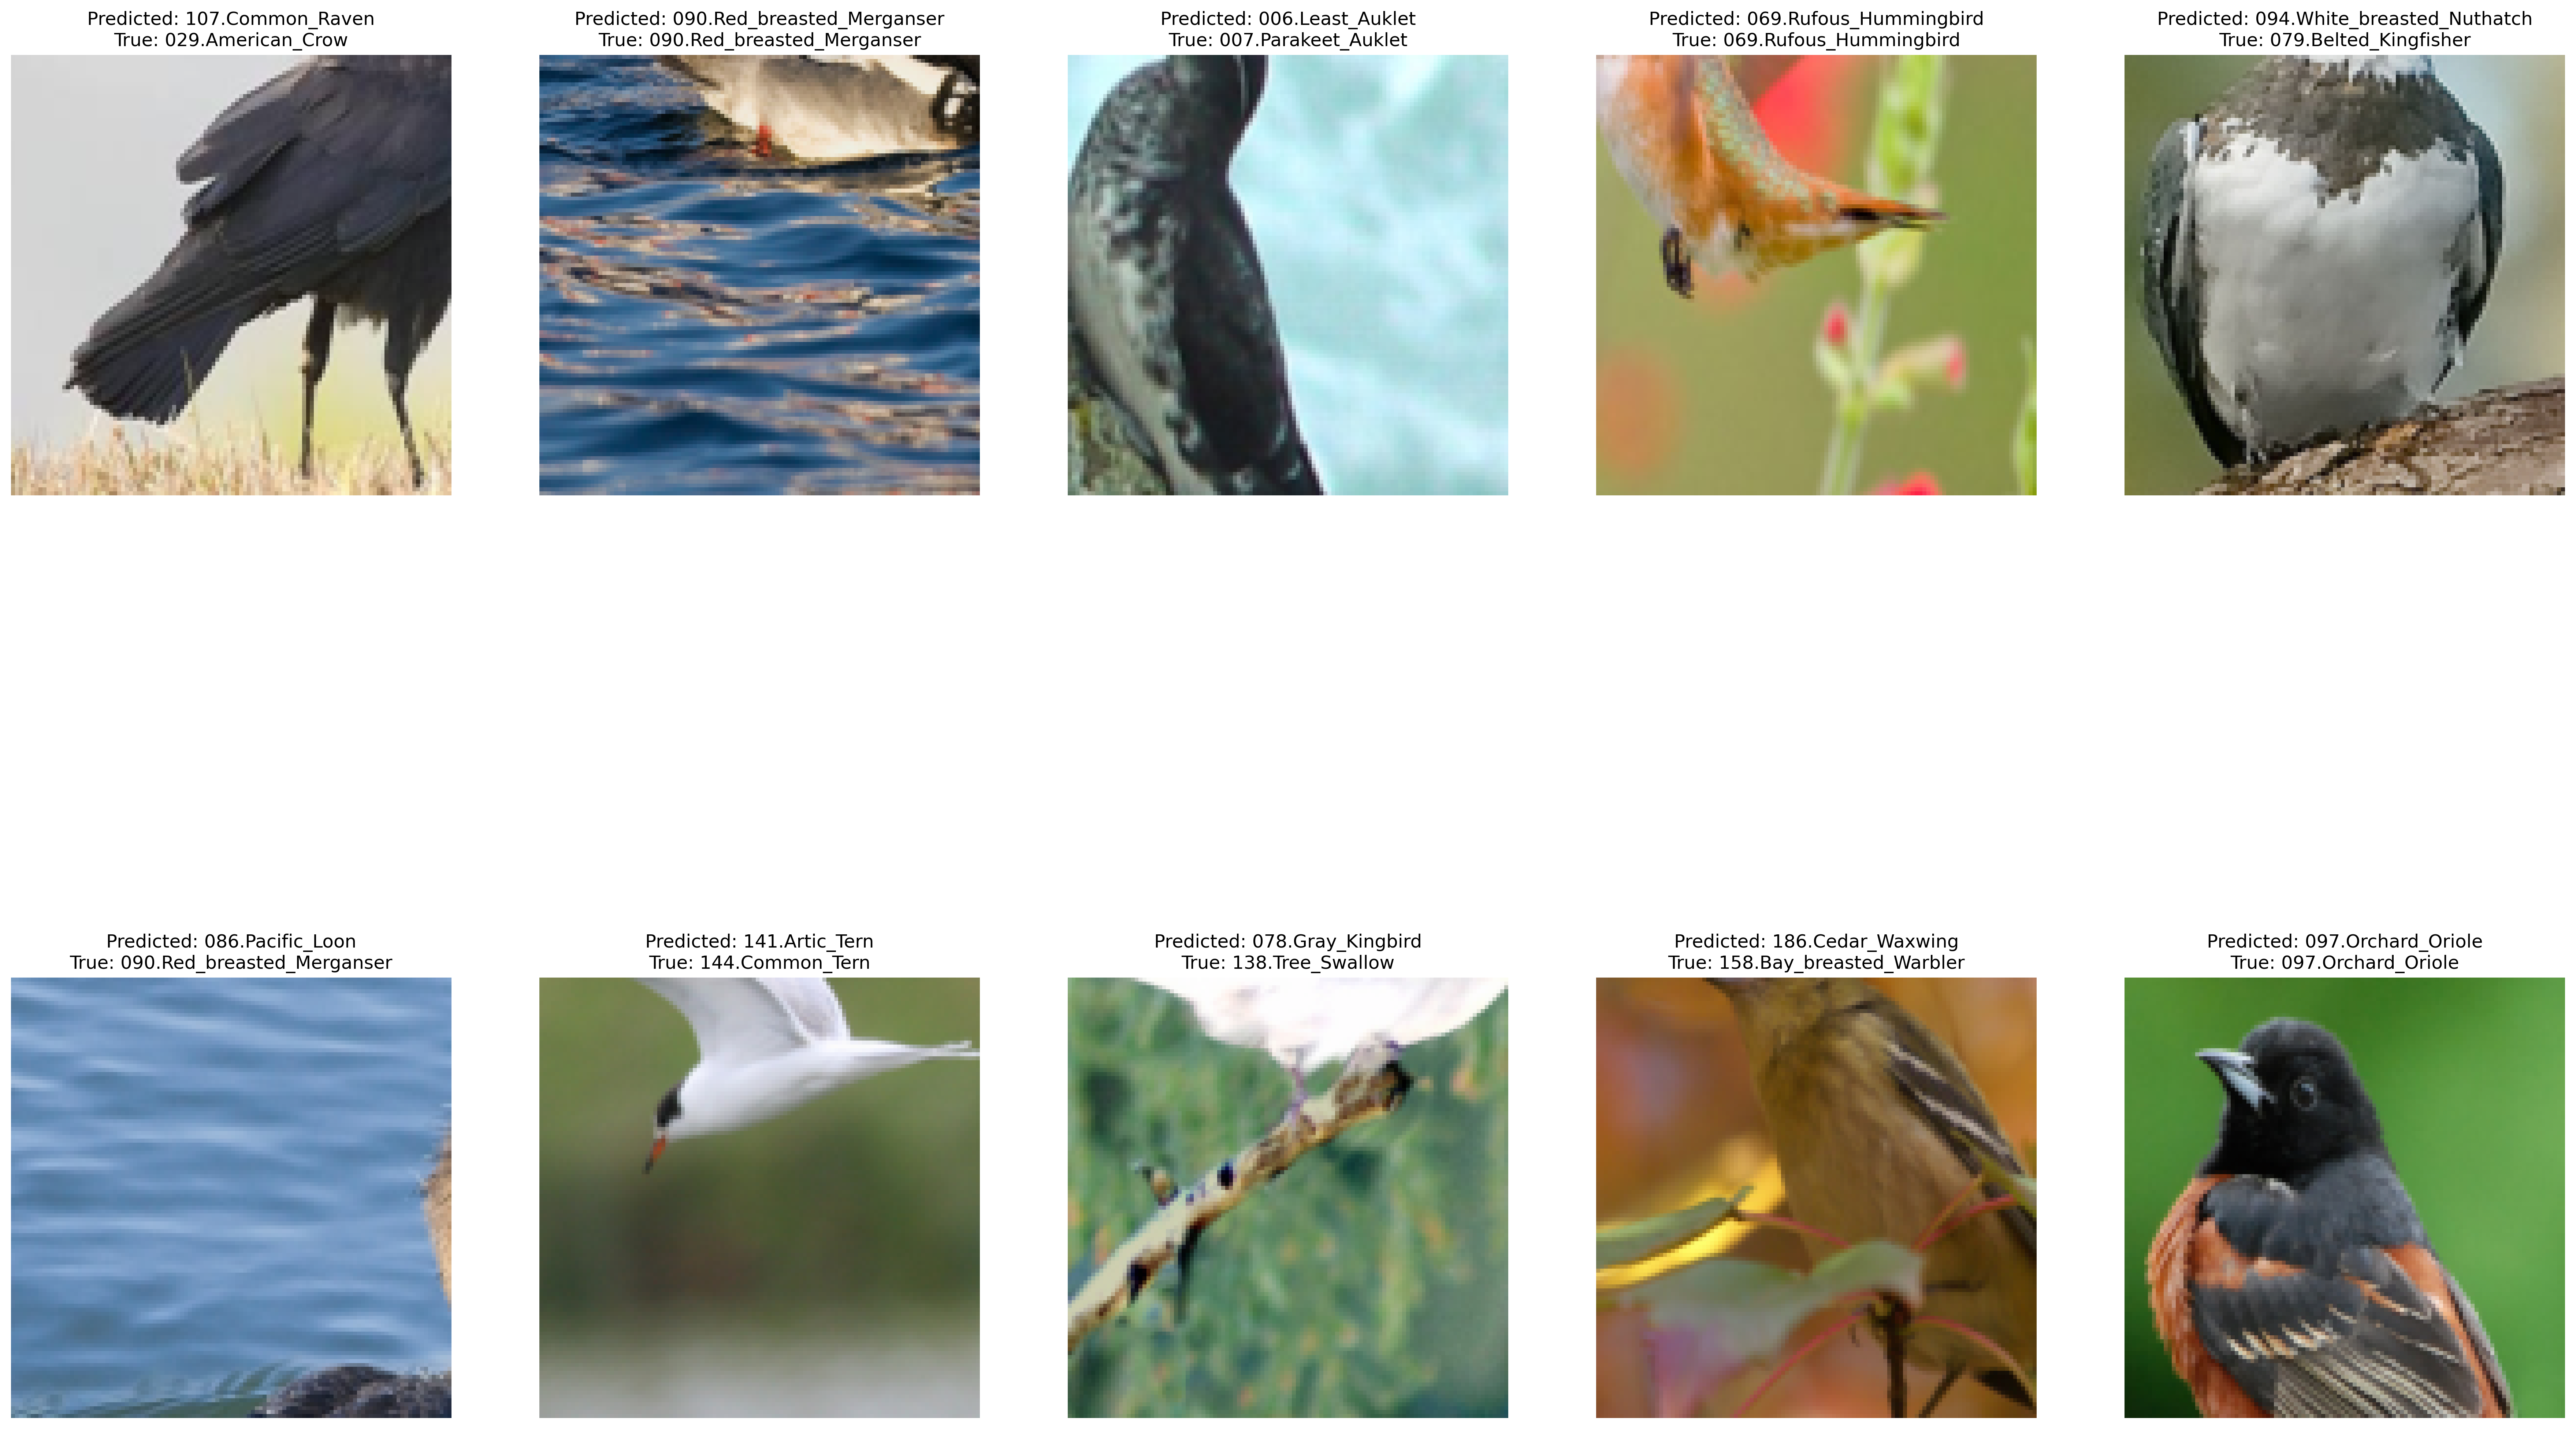

In [22]:
"""
Code from Vision_mnasnet1_3.ipynb to view the model performance and its mistakes.
Reload the model that I trained the day before.
Viewing the performance of the FIRST model on the validation data here:
"""
#reload the FIRST trained model:
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 200) #change to 200 number of classes output for 200 classes in CUB-200-2011 dataset
model = model.to(device)
model.load_state_dict(torch.load('output/alexnet_lab7_best.pth'))


# Set the model to evaluation mode
model.eval()

# Randomly select 10 images from the validation set
random_indices = random.sample(range(len(new_val)), 10)
images, true_labels = zip(*[new_val[i] for i in random_indices])

# Function to unnormalize and convert a tensor to a PIL image
def unnormalize_and_convert_to_pil(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(tensor.device)
    tensor = tensor.clone().detach()  # Clone the tensor
    tensor = tensor.mul_(std).add_(mean)  # Unnormalize
    tensor = tensor.clamp(0, 1)  # Clamp to the range [0, 1]
    return to_pil_image(tensor)

# Predict and display
plt.figure(figsize=(30, 20), dpi=300)
for i, (image, true_label) in enumerate(zip(images, true_labels)):
    # Predict
    image_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_label = test.classes[predicted[0]]

    # Convert image for display
    image_pil = unnormalize_and_convert_to_pil(image)

    # Display
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_pil)
    plt.title(f'Predicted: {predicted_label}\nTrue: {test.classes[true_label]}')
    plt.axis('off')
plt.show()